In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime
from IPython.display import clear_output
from datetime import timedelta
from scipy.stats import skewnorm
import inspect, re
import h2o
from h2o.automl import H2OAutoML
import xgboost as xgb
               
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
fy_10 = pd.read_csv('fy_10.csv')
fy_11 = pd.read_csv('fy_11.csv')
fy_12 = pd.read_csv('fy_12.csv')
fy_13 = pd.read_csv('fy_13.csv')
fy_14 = pd.read_csv('fy_14.csv')
fy_15 = pd.read_csv('fy_15.csv')

In [15]:
drop_list = ['GL Description','GL Category Description','Revenue or Expenditure']

train_list = [fy_10, fy_11, fy_12, fy_13]
test_list = [fy_14, fy_15]

X_train = pd.concat(train_list).drop(['OA_Difference','Actuals','Current Budget']+drop_list, axis=1)
X_test = pd.concat(test_list).drop(['OA_Difference', 'Actuals', 'Current Budget']+drop_list, axis = 1)
y_train = pd.concat(train_list)['OA_Difference']
y_test = pd.concat(test_list)['OA_Difference']

In [16]:
model = xgb.XGBRegressor()
model.fit(X_train,y_train)
print (model)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:24:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)


In [17]:
xgb_test_predictions = model.predict(X_test)
xgb_train_predictions = model.predict(X_train)

In [18]:
np.sqrt(np.mean((xgb_test_predictions-y_test)**2))

890668.0595617504

Text(0, 0.5, 'predictions')

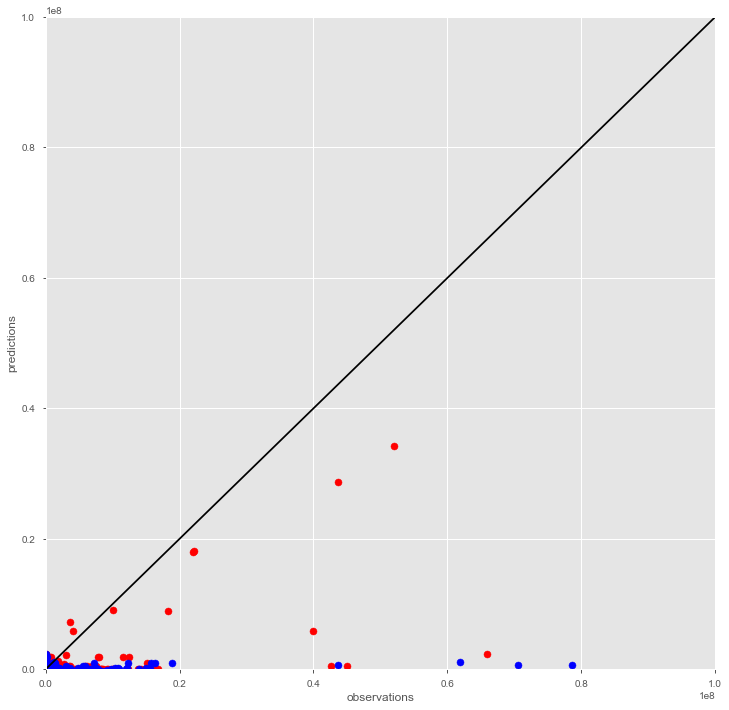

In [19]:
x = np.linspace(-100000000,100000000,100000000)
plt.figure(figsize=(12,12))
plt.scatter(y_train, xgb_train_predictions, c='red')
plt.scatter(y_test, xgb_test_predictions, c='blue')
#plt.scatter(train_df['voyage_duration'], train_df['eta_diff'], c='green')
plt.plot(x,x,c='black')
plt.xlim([-5,100000000])
plt.ylim([-5,100000000])
plt.xlabel('observations')
plt.ylabel('predictions')

# H2o

In [24]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,3 days 20 hours 9 mins
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,1 month and 7 days
H2O cluster name:,H2O_from_python_josephdown_bis3r7
H2O cluster total nodes:,1
H2O cluster free memory:,3.590 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [25]:
X_train = pd.concat(train_list).drop(['OA_Difference','Actuals','Current Budget'], axis=1)
X_test = pd.concat(test_list).drop(['OA_Difference', 'Actuals', 'Current Budget'], axis = 1)
y_train = pd.concat(train_list)['OA_Difference']
y_test = pd.concat(test_list)['OA_Difference']

In [26]:
# create h2o frame for training data
training_frame = pd.concat([X_train,y_train], axis=1)
training_frame.columns = list(training_frame.columns[:-1]) + ['OA_Difference']
training_frame = h2o.H2OFrame(training_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [27]:
# create h2o frame for testing data
testing_frame = pd.concat([X_test,y_test], axis=1)
testing_frame.columns = list(testing_frame.columns[:-1]) + ['OA_Difference']
testing_frame = h2o.H2OFrame(testing_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [28]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(None, 'OA_Difference', training_frame)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [32]:
y_test.std()

889447.1949689658

In [29]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((predicted_actuals['predict'].as_data_frame()['predict'].values-y_test)**2))

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/anaconda3/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'GL Description' has levels not trained on: [500045 - Patrol Incentive Pay, 520117 - Security Equipment Services, 520149 - Internship Program, 520739 - Ambulance Refund, 520757 - Maintenance Renewal and Replacement, 521205 - Short Term Compensated Absence Expense, 521306 - Indirect Cost  - PWE, 521735 - Hobby Parking Space Rental, 531015 - Public Improvement Bond Principal Retire, 531035 - Promissory note Principal, 531080 - Certificates of Obligation Interest, 532135 - Ch.380 - Transfers to Other Funds, 551005 - Fixed Assets Restatement, 560280 - Cap Exp - Intangibles No Amortization Bk]
  warnings.warn(w)


869969.2552067629

In [31]:
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20190903_113110

Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,47.0,47.0,22207.0,7.0,7.0,7.0,8.0,28.0,13.936171




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 250294557611.95975
RMSE: 500294.4708988495
MAE: 36683.40504039283
RMSLE: NaN
Mean Residual Deviance: 250294557611.95975

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 511905324125.28217
RMSE: 715475.5929626685
MAE: 43510.25916318126
RMSLE: NaN
Mean Residual Deviance: 511905324125.28217
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,43510.28,2539.309,36564.434,45233.34,46574.953,45468.613,43710.062
mean_residual_deviance,511904121000.0000000,154908377000.0000000,165326389000.0000000,720222030000.0000000,772234540000.0000000,475677917000.0000000,426059629000.0000000
mse,511904121000.0000000,154908377000.0000000,165326389000.0000000,720222030000.0000000,772234540000.0000000,475677917000.0000000,426059629000.0000000
r2,0.2616802,0.1200337,0.2755291,0.2308147,-0.0152330,0.3012712,0.5160187
residual_deviance,511904121000.0000000,154908377000.0000000,165326389000.0000000,720222030000.0000000,772234540000.0000000,475677917000.0000000,426059629000.0000000
rmse,695291.56,119318.43,406603.47,848659.0,878768.75,689694.06,652732.44
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-09-03 11:45:14,38.927 sec,0.0,835040.7056522,49755.7055267,697292980096.1229248
,2019-09-03 11:45:14,39.352 sec,5.0,732038.7357989,44830.6113923,535880710710.0418091
,2019-09-03 11:45:15,39.742 sec,10.0,651233.7115692,41610.4461294,424105347084.1557617
,2019-09-03 11:45:15,40.144 sec,15.0,614371.8276285,39741.6951874,377452742583.6177979
,2019-09-03 11:45:15,40.531 sec,20.0,575195.2679526,38480.2358254,330849596275.0733032
,2019-09-03 11:45:16,40.931 sec,25.0,553391.9810258,37709.4257082,306242684663.6531372
,2019-09-03 11:45:16,41.319 sec,30.0,536325.1644520,37209.7771750,287644682024.4435425
,2019-09-03 11:45:16,41.708 sec,35.0,528390.1222623,37118.9757224,279196121304.3279419
,2019-09-03 11:45:17,42.121 sec,40.0,515420.9523232,36968.6837794,265658758093.7703552
,2019-09-03 11:45:17,42.528 sec,45.0,504751.8778232,36776.5568569,254774458166.0968323


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
GL Description,126710382864629760.0000000,1.0,0.4961038
Original Budget,97285733718425600.0000000,0.7677803,0.3808987
Unnamed: 0,15718349795229696.0000000,0.1240494,0.0615414
Business Area Name_Public Works & Engineering-PWE,2424737745600512.0000000,0.0191361,0.0094935
Astros Yearly Attendance,1847473203052544.0000000,0.0145803,0.0072333
---,---,---,---
Business Area Name_Mayor's Office,0.0,0.0,0.0
Business Area Name_Municipal Courts Department,0.0,0.0,0.0
Business Area Name_Parks & Recreation,0.0,0.0,0.0
Business Area Name_Planning & Development,0.0,0.0,0.0



See the whole table with table.as_data_frame()


gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/anaconda3/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'GL Description' has levels not trained on: [500045 - Patrol Incentive Pay, 520117 - Security Equipment Services, 520149 - Internship Program, 520739 - Ambulance Refund, 520757 - Maintenance Renewal and Replacement, 521205 - Short Term Compensated Absence Expense, 521306 - Indirect Cost  - PWE, 521735 - Hobby Parking Space Rental, 531015 - Public Improvement Bond Principal Retire, 531035 - Promissory note Principal, 531080 - Certificates of Obligation Interest, 532135 - Ch.380 - Transfers to Other Funds, 551005 - Fixed Assets Restatement, 560280 - Cap Exp - Intangibles No Amortization Bk]
  warnings.warn(w)


Text(0, 0.5, 'predictions')

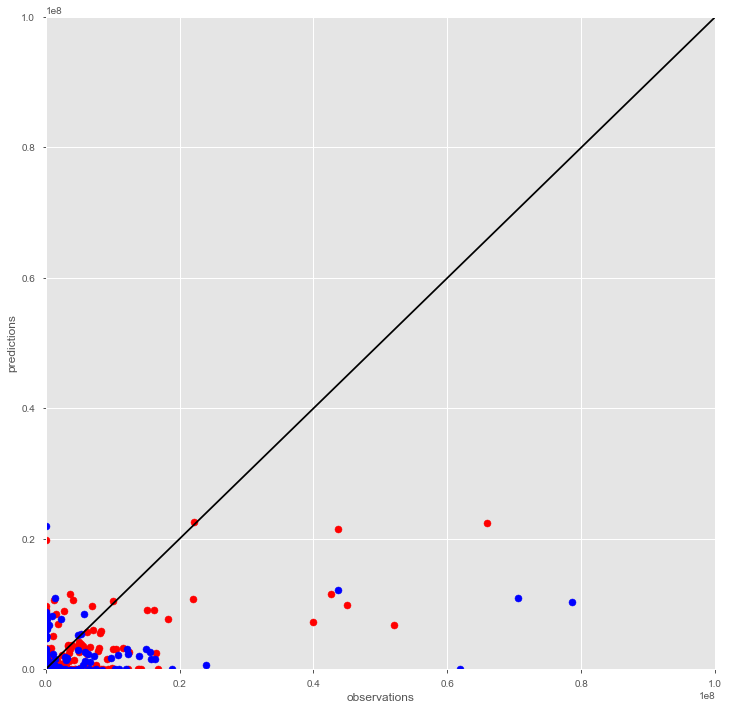

In [30]:
x = np.linspace(-100000000,100000000,100000000)
plt.figure(figsize=(12,12))
plt.scatter(y_train, aml.predict(training_frame).as_data_frame()['predict'].values, c='red')
plt.scatter(y_test, aml.predict(testing_frame).as_data_frame()['predict'].values, c='blue')
#plt.scatter(train_df['voyage_duration'], train_df['eta_diff'], c='green')
plt.plot(x,x,c='black')
plt.xlim([-5,100000000])
plt.ylim([-5,100000000])
plt.xlabel('observations')
plt.ylabel('predictions')
